# ASSIGNMENT 3
Group members: **Henri Chemla** (hche697) - leader, Phawat Saengsiripongpun (psae970), Shawna Chandra (schb813), Hoang Nguyen (mugn737), Trey Miller-Henry (tmil533), Charles Benson (cben751)

We chose not to write a separate report, instead we have explained everything thoroughly in this notebook file, as per the rubric.

## Task 1: Exploratory Data Analytics

In [3]:
# Importing some handy libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

First we looked at the specs of the given dataset, in the training dataset we have 428 articles and 13518 unique words/tokens.
We then analysed the word frequency in the training dataset. We print the 50 most common terms for the entire dataset and also plot a bar chart showing the distribution of those 50 words.

As is, the data is very clean (all lower-case, no punctuation etc) so we did minimal pre-processing, essentially just vectorisation.
For vectorisation we used CountVectorizer from sklearn with the fit_transform() which builds a matrix of the vocabulary with counts for each unique word. We print the first rows (articles) with their features.

Training data dimensions/information: 

Row and column size of the training data : 428 rows, 3 columns
Row and column size of the testing data : 106 rows, 3 columns

The columns in the dataset are: ['ArticleId', 'Text', 'Category']

Number of training articles: 428
The number of extracted features is: 13518
Vector shape: (5, 13518)

Article vectors for the first 5 lines
 [[0.         0.02011467 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.0545515  0.        ]]


Top 50 frequent terms overall:


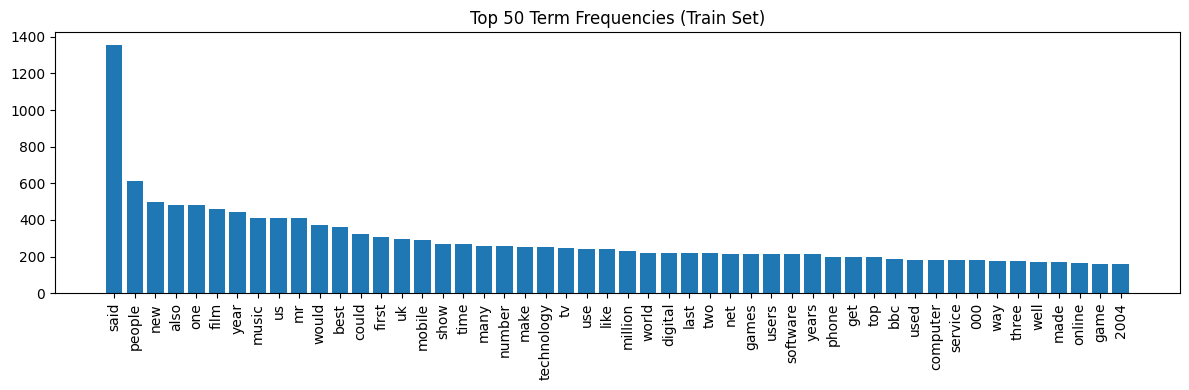


Top 50 frequent terms in category 'tech':


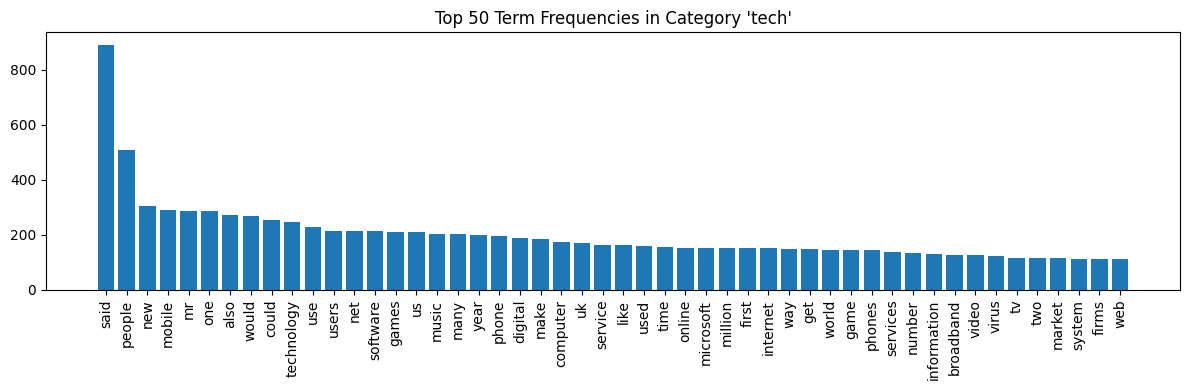


Top 50 frequent terms in category 'entertainment':


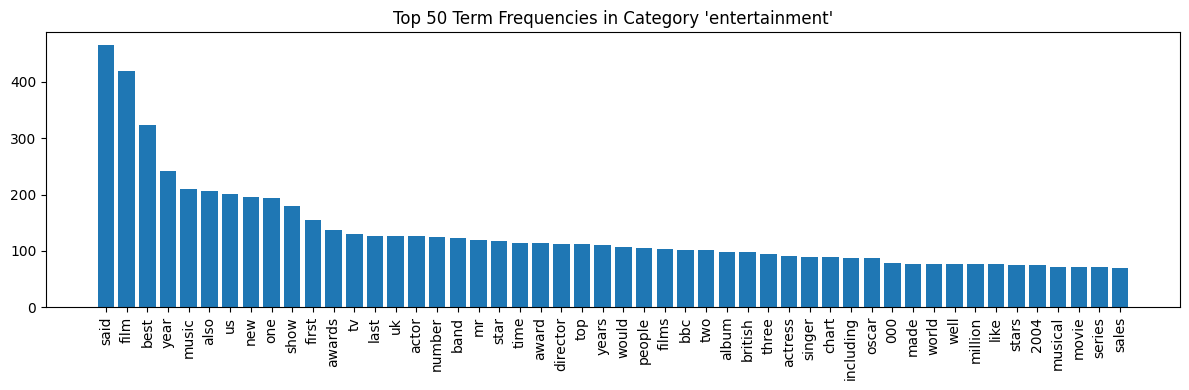


Distribution of classes in the training set:


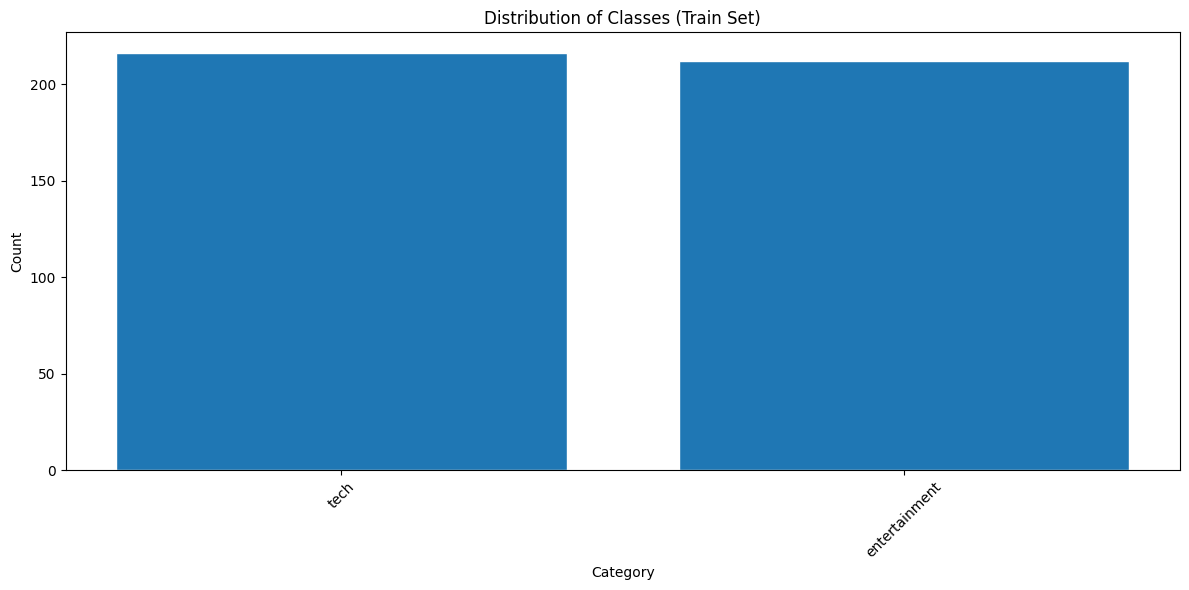

In [ ]:
# Prepare train and test data
train_path = "train.csv"
test_path  = "test.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Training data dimensions/information: \n")
print(f"Row and column size of the training data : {train_df.shape[0]} rows, {train_df.shape[1]} columns")
print(f"Row and column size of the testing data : {test_df.shape[0]} rows, {test_df.shape[1]} columns")
print("\nThe columns in the dataset are:", train_df.columns.tolist())
print()



# FIRST FIVE ROWS OF THE TRAINING DATA WITH DESCRIPTIONS VECTORIZED

# Encode document
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['Text'])
X_test = vectorizer.transform(test_df['Text'])
y_train = train_df['Category']
y_test = test_df['Category']
print(f"Number of training articles: {X_train.shape[0]}")
print(f"The number of extracted features is: {X_train.shape[1]}")
vector = vectorizer.transform(train_df['Text'].iloc[0:5])

# Summarize encoded vector


print(f'Vector shape: {vector.shape}\n')
print(f'Article vectors for the first 5 lines\n {vector.toarray()}')


# VISUALISATIONS
count_vec = CountVectorizer()
word_counts = count_vec.fit_transform(train_df['Text'])
total_counts = np.array(word_counts.sum(axis=0)).flatten()
vocab = count_vec.get_feature_names_out()


# Get top 50 overall frequent terms
top50_idx = total_counts.argsort()[-50:][::-1]
print("\n\nTop 50 frequent terms overall:")
top_50_idx = total_counts.argsort()[-50:][::-1]
plt.figure(figsize=(12, 4))
plt.bar([vocab[i] for i in top_50_idx], total_counts[top_50_idx])
plt.xticks(rotation=90)
plt.title("Top 50 Term Frequencies (Train Set)")
plt.tight_layout()
plt.show()


#Get top 50 frequent terms for each class
categories = train_df['Category'].unique()
for category in categories:
    category_df = train_df[train_df['Category'] == category]
    word_counts = count_vec.transform(category_df['Text'])
    total_counts = np.array(word_counts.sum(axis=0)).flatten()
    top50_idx = total_counts.argsort()[-50:][::-1]
    print(f"\nTop 50 frequent terms in category '{category}':")
    plt.figure(figsize=(12, 4))
    plt.bar([vocab[i] for i in top50_idx], total_counts[top50_idx])
    plt.xticks(rotation=90)
    plt.title(f"Top 50 Term Frequencies in Category '{category}'")
    plt.tight_layout()
    plt.show()


# Getting the distribution of classes
print("\nDistribution of classes in the training set:")
plt.figure(figsize=(12, 6))
plt.bar(train_df['Category'].value_counts().index, train_df['Category'].value_counts().values, edgecolor='white')
plt.title("Distribution of Classes (Train Set)")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Here we can see that for the overall dataset, the word "said" is very common in the dataset, occurring more than twice the amount of the second most common word "people". Following from those two words, the frequency of the words follows a gradual and reasonably uniform downward trend.

We also did some more analysis more specific to the two classes.

In the Tech class the two most common words are "said" and "people", the same as the overall dataset. In the rest of the most common words in the Tech class, there are understandably more tech specific terms which did not show up in the most common words of the overall dataset such as "broadband" and "microsoft".

In the Entertainment class, there are three noticeably common words, "said", "film", and "best" these are relatively close to each other in frequency and form a more uniform curve downwards compared to the Tech class and overall dataset in which the most common term/s stand out much more than the rest.

Lastly we looked at the amount of Tech and Entertainment articles there were in the training dataset, which was 216 and 212 respectively.

## Task 2: Classification Models Learning

This code performs PCA to reduce the high-dimensional text data to 2D for visualization. It then creates a function that plots a classifier's decision boundaries and data points in this reduced space. The function generates a grid of points, makes predictions across the grid to map decision regions, and displays the results with different colors for each class with tech being blue and entertainment being red.

Projecting a high-dimensional data point into a lower-dimensional PCA space, we capture its most significant features while reducing dimensionality and therefore complexity. Reconstructing it then provides a good approximation of the original, even though it loses some less important data points in the prior process of dimension reduction.

In [5]:
# Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train.toarray())   # convert sparse to dense for PCA
X_test_2D = pca.transform(X_test.toarray())

# Create plot_2d_decision_boundary() function for visualsation of learning algorithms
import matplotlib.colors as mcolors

def plot_2d_decision_boundary(
    model,                  # Trained classifier
    X,                      # 2D feature array (e.g., PCA-reduced)
    y,                      # Label array (for scatter)
    title,                  # Plot title
    inverse_transform=None  # Optional, e.g. pca.inverse_transform
):
    # Create mesh grid (reduced resolution from 200 → 100)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))  # 100x100 grid

    # Predict on mesh grid points
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    if inverse_transform is not None:
        mesh_points = inverse_transform(mesh_points)
    Z_labels = model.predict(mesh_points)
    classes = model.classes_
    Z = np.array([np.where(classes == label)[0][0] for label in Z_labels])
    Z = Z.reshape(xx.shape)

    # Plot contour
    plt.figure()
    cmap = mcolors.ListedColormap(['#FF3333', '#3333FF'])
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)

    # Plot training points
    plt.scatter(X[y == 'tech', 0], X[y == 'tech', 1], label='tech', s=20, edgecolor='k')
    plt.scatter(X[y == 'entertainment', 0], X[y == 'entertainment', 1], label='entertainment', s=20, edgecolor='k')
    plt.legend()
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()


### Naive Bayes

This trains a Naive Bayes classifier on text data, then identifies and prints the top 20 most predictive words for each class and the 20 most discriminative words between the classes based on log probability ratios.

In [6]:
# Import required modules
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB(alpha=1.0)  # Laplace smoothing alpha=1
nb_clf.fit(X_train, train_df['Category'])

# (i) Top-20 words per class
for index, class_label in enumerate(nb_clf.classes_):
    top20_idx = np.argsort(nb_clf.feature_log_prob_[index])[-20:][::-1]
    print(f"Class '{class_label}':", list(vocab[top20_idx]))

# (ii) Top-20 most discriminative words by log-ratio
diff = nb_clf.feature_log_prob_[0] - nb_clf.feature_log_prob_[1]
top20_idx = np.argsort(np.abs(diff))[-20:][::-1]
print("\nTop-20 most discriminative words by log-ratio: \n")
for i in top20_idx:
    sign = "tech" if diff[i] > 0 else "ent"
    print(f"{vocab[i]}: {diff[i]:.2f} ({sign})")

Class 'entertainment': ['film', 'best', 'said', 'show', 'band', 'music', 'year', 'awards', 'us', 'award', 'actor', 'album', 'star', 'chart', 'tv', 'also', 'number', 'oscar', 'top', 'new']
Class 'tech': ['said', 'people', 'mobile', 'software', 'games', 'phone', 'net', 'users', 'technology', 'mr', 'microsoft', 'virus', 'computer', 'broadband', 'new', 'use', 'could', 'would', 'digital', 'game']

Top-20 most discriminative words by log-ratio: 

mobile: -2.13 (ent)
film: 1.90 (tech)
software: -1.90 (ent)
users: -1.81 (ent)
band: 1.80 (tech)
microsoft: -1.79 (ent)
games: -1.79 (ent)
net: -1.78 (ent)
technology: -1.75 (ent)
virus: -1.74 (ent)
phone: -1.73 (ent)
broadband: -1.72 (ent)
best: 1.68 (tech)
computer: -1.65 (ent)
actor: 1.62 (tech)
phones: -1.61 (ent)
album: 1.61 (tech)
chart: 1.57 (tech)
oscar: 1.55 (tech)
spam: -1.52 (ent)


Which list of words decribe the two classes better?

- List(i) (highest P(word|class)) includes tokens that appear frequently in that class, but they might also appear (to some extent) in the other class; not always highly discriminative
- List (ii) (highest log-ratio) focuses on tokens that occur almost exclusively in one class but rarely in the other. As a result, they do a better job of describing each class in terms of uniqe vocabulary

Conclusion: list (ii) better captures the distinctive language of each category.

### (b) k-Nearest Neighbours (kNN)

We train a k-Nearest Neighbors (kNN) classifier with $k=5$ and Euclidean distance. We then predict categories for the test set, print a class report summary, and visualise the decision boundary.

               precision    recall  f1-score   support

entertainment       0.98      0.98      0.98        61
         tech       0.98      0.98      0.98        45

     accuracy                           0.98       106
    macro avg       0.98      0.98      0.98       106
 weighted avg       0.98      0.98      0.98       106



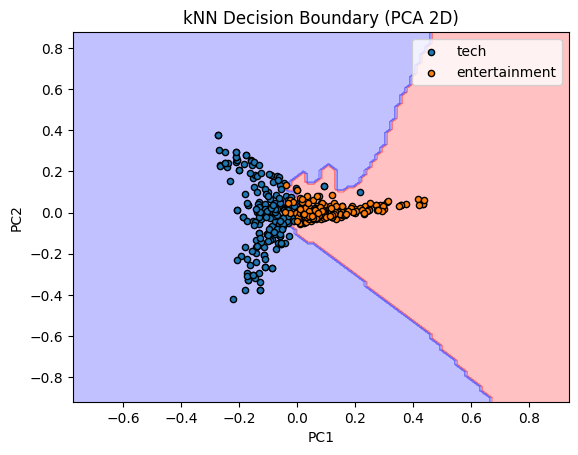

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

knn_clf = KNeighborsClassifier(n_neighbors=5, metric='euclidean', n_jobs=-1)  # Using all available cores

# Fit kNN on the PCA-reduced 2D data
knn_clf.fit(X_train_2D, train_df['Category'])
y_pred_knn = knn_clf.predict(X_test_2D)
print(classification_report(test_df['Category'], y_pred_knn))

plot_2d_decision_boundary(
    model=knn_clf,
    X=X_train_2D,
    y=train_df['Category'].values,
    title="kNN Decision Boundary (PCA 2D)"
)

The k-Nearest Neighbours (kNN) classifier was trained using text data transformed with CountVectorizer, then reduced to
two dimensions using PCA for visualisation. PCA was chosen as it preserves the most variance and allows the effects of
different k values and distance metrics on decision boundaries to be clearly shown.

The best training accuracy (100%) was achieved with k = 1 using Manhattan distance, but this is likely overfitting, as
the model effectively memorises the training data. In practice, using a slightly higher k, such as 3 or 5, would
provide better generalisation and a more realistic sense of how the model might perform on unseen data.

The decision boundary plot highlights the impact of these hyperparameters. A smaller k results in complex boundaries
that respond to minor fluctuations in the data, making the model sensitive to noise. In contrast, a
larger k smooths out the boundary, reducing this sensitivity but potentially missing finer distinctions between
classes. The distance metric also plays an important role: Manhattan distance (p = 1) produces more angular,
box-like regions, while Euclidean distance (p = 2) creates rounder, more continuous boundaries. These differences
affect how the model interprets the space and classifies points near the boundaries.

### (c) Support Vector Machine (SVM)

(i) Soft-Margin Linear SVM

For this task, we use SVC(kernel='linear'). The hyperparameter C controls the trade-off between achieving a large margin and correctly classifying all training examples. A smaller C means a larger margin is prioritised at the cost of more training errors, while a larger C penalizes errors more heavily, leading to a narrower margin and a more complex model that may overfit. We start with C=1.0 as a default and balanced choice.


               precision    recall  f1-score   support

entertainment       0.98      0.98      0.98        61
         tech       0.98      0.98      0.98        45

     accuracy                           0.98       106
    macro avg       0.98      0.98      0.98       106
 weighted avg       0.98      0.98      0.98       106



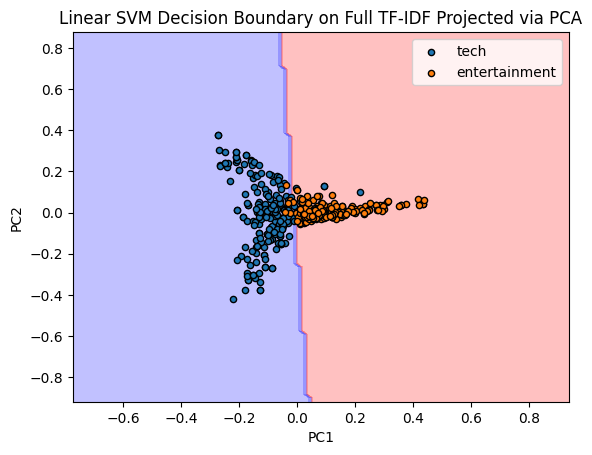

In [8]:
# SOFT-MARGIN LINEAR SVM

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

linear_svm = SVC(kernel='linear', C=1.0)
# Train the linear SVM model using the 2D PCA-reduced training data
linear_svm.fit(X_train_2D, train_df['Category'])
# Predict the categories for the 2D PCA-reduced test data
y_pred_linear = linear_svm.predict(X_test_2D)
print(classification_report(test_df['Category'], y_pred_linear))

# The plot shows the data points and the boundary learned by the SVM.
plot_2d_decision_boundary(
    model=linear_svm,
    X=X_train_2D,
    y=train_df['Category'].values,
    title="Linear SVM Decision Boundary on Full TF-IDF Projected via PCA"
)

###(ii) Hard-Margin RBF Kernel SVM

RBF kernel adds a gamma parameter, which defines the kernel width or spread of the Gaussian. For this model, we use a relatively large C to approximate a hard-margin fit, meaning the SVM will try to classify all points correctly. Since we are using a hard-margin SVM with an RBF kernel, gamma determines the influence of individual training examples on the decision boundary. A common heuristic is gamma = 1/num_features, but for this dataset, that value would be very small (1/13518), resulting in almost linear behavior. To allow for more non-linearity, we will initially set gamma to 0.1, with the final value to be determined by cross-validation.


               precision    recall  f1-score   support

entertainment       0.98      0.98      0.98        61
         tech       0.98      0.98      0.98        45

     accuracy                           0.98       106
    macro avg       0.98      0.98      0.98       106
 weighted avg       0.98      0.98      0.98       106



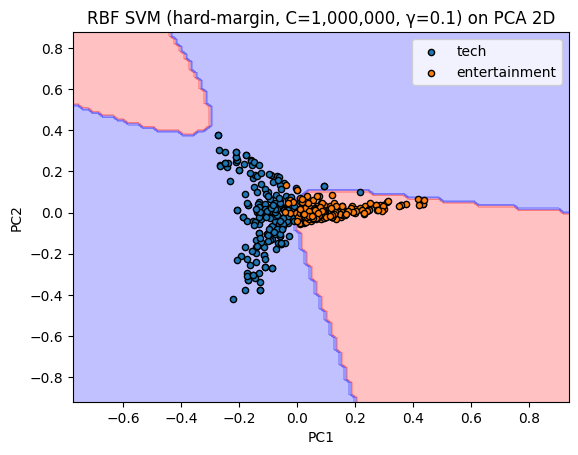

In [9]:

# HARD-MARGIN RBF KERNEL SVM

# Initialize an RBF Kernel SVM classifier.
rbf_svm = SVC(kernel='rbf', C=1000000, gamma=0.1)

# Train the RBF SVM model using the 2D PCA-reduced training data
rbf_svm.fit(X_train_2D, train_df['Category'])
# Predict the categories for the 2D PCA-reduced test data
y_pred_rbf = rbf_svm.predict(X_test_2D)
print(classification_report(test_df['Category'], y_pred_rbf))

# Plot the decision boundary of the trained RBF SVM model.
plot_2d_decision_boundary(
    model=rbf_svm,
    X=X_train_2D,
    y=train_df['Category'].values,
    title="RBF SVM (hard-margin, C=1,000,000, γ=0.1) on PCA 2D"
)

## (d) Neural Network (NN)

Using a one (hidden) layer neural network, we tested different amounts of neurons inside the layer to see how they would do. We used ReLU as our activation function, and the Adam optimiser.

We test three networks, each having 5, 20, and 40 neurons in the hidden layer.

               precision    recall  f1-score   support

entertainment       1.00      1.00      1.00        61
         tech       1.00      1.00      1.00        45

     accuracy                           1.00       106
    macro avg       1.00      1.00      1.00       106
 weighted avg       1.00      1.00      1.00       106



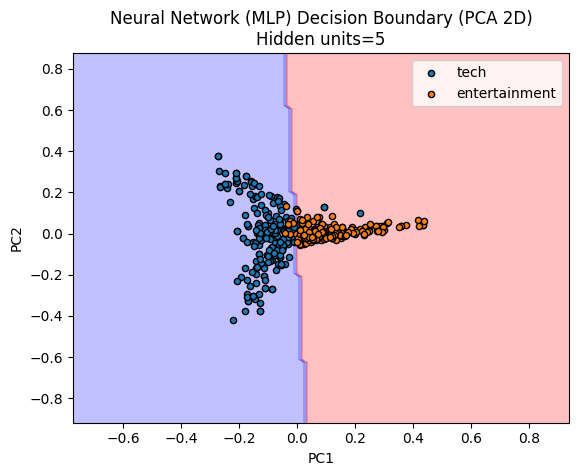

               precision    recall  f1-score   support

entertainment       1.00      0.98      0.99        61
         tech       0.98      1.00      0.99        45

     accuracy                           0.99       106
    macro avg       0.99      0.99      0.99       106
 weighted avg       0.99      0.99      0.99       106



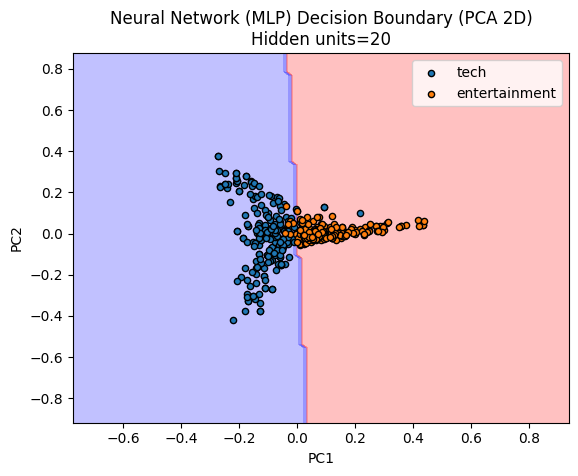

               precision    recall  f1-score   support

entertainment       1.00      0.98      0.99        61
         tech       0.98      1.00      0.99        45

     accuracy                           0.99       106
    macro avg       0.99      0.99      0.99       106
 weighted avg       0.99      0.99      0.99       106



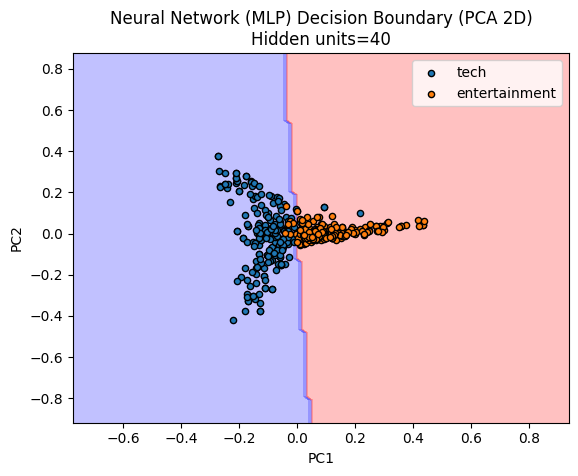

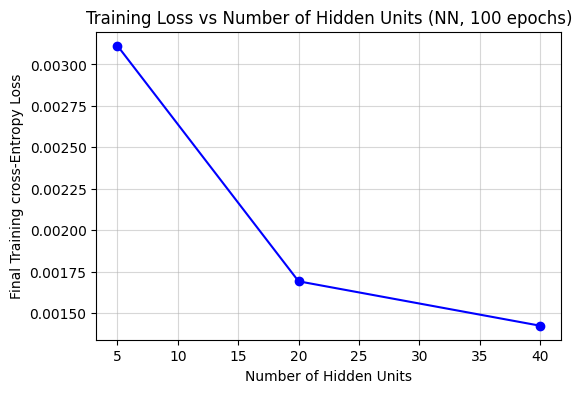

In [10]:
from sklearn.neural_network import MLPClassifier

# Define a list of different numbers of hidden units to experiment with
hidden_units = [5, 20, 40]
# Initialize an empty list to store the final training loss for each MLP model
final_losses = []

# Iterate through each specified number of hidden units
for h in hidden_units:
    mlp_clf = MLPClassifier(
        hidden_layer_sizes=(h,),
        activation='relu',
        solver='adam',
        learning_rate_init=0.01,
        max_iter=100,
        random_state=0,
        verbose=False
    )

    # Train the MLP model using the training data
    mlp_clf.fit(X_train, train_df['Category'])
    # Predict the categories for the test data (X_test contains features)
    y_pred_mlp = mlp_clf.predict(X_test)
    print(classification_report(test_df['Category'], y_pred_mlp))
    # Get the final training loss from the loss_curve_ attribute of the trained model
    loss = mlp_clf.loss_curve_[-1]
    # Append the final loss to the list
    final_losses.append(loss)

    plot_2d_decision_boundary(
        model=mlp_clf,
        X=X_train_2D,
        y=train_df['Category'].values,
        title=f"Neural Network (MLP) Decision Boundary (PCA 2D)\nHidden units={h}",
        inverse_transform=pca.inverse_transform  # Important for original-space models!
    )

# final training loss plot
plt.figure(figsize=(6, 4))
plt.plot(hidden_units, final_losses, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Final Training cross-Entropy Loss')
plt.title('Training Loss vs Number of Hidden Units (NN, 100 epochs)')
plt.grid(alpha=0.5)
plt.show()

Based on the plot, as the number of hidden units in the neural network increases, the final training cross-entropy loss decreases. The graph shows a steep drop in loss when the number of units is increased from 5 to 20, followed by a smaller decrease when moving from 20 to 40 units. The improvement in training loss is not linear. The sharpest decrease is from 5 to 20 units. The smaller improvement between 20 and 40 units suggests diminishing returns, where adding more units yields progressively less benefit in reducing the training loss.



## Task 3: Classification Quality Evaluation
(a)

This evaluates the performance (F₁ score) of four classifiers—Naive Bayes, k-NN, SVM, and NN on varying partitions of the training dataset. Plotting both validation F₁ scores, and test F₁ scores to analyze how models accuracy change with training size.


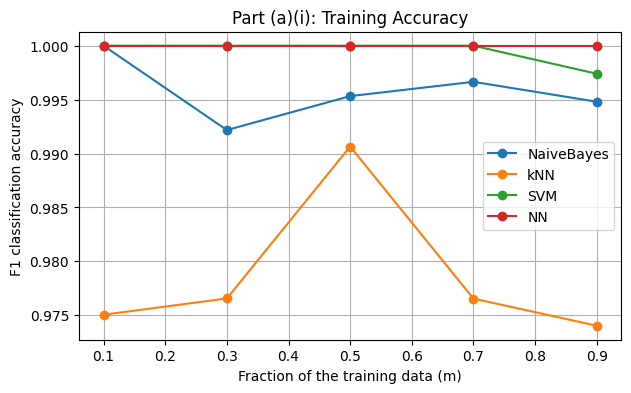

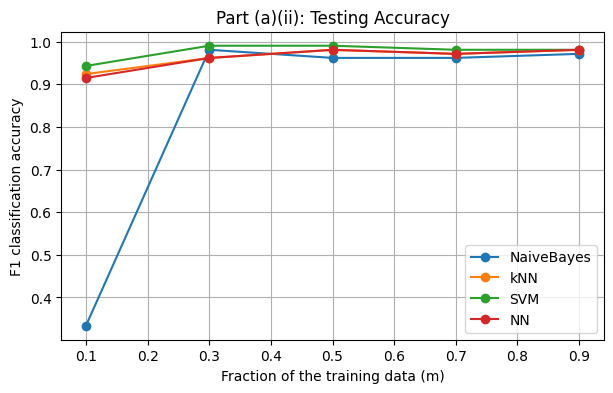

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics            import f1_score
from sklearn.model_selection    import KFold, cross_val_score, ParameterGrid
from sklearn.naive_bayes        import MultinomialNB
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.svm                import SVC
from sklearn.neural_network     import MLPClassifier
import pandas as pd


# F₁ vs. training‐set fraction (four curves only: NB, kNN, SVM, MLP)
models_a = {
    "NaiveBayes": MultinomialNB(alpha=1.0),
    "kNN":   KNeighborsClassifier(n_neighbors=5, metric='euclidean', n_jobs=-1),
    "SVM":        SVC(kernel='linear', C=1.0),   # single SVM line for Part (a)
    "NN":    MLPClassifier(
                      hidden_layer_sizes=(20,),
                      activation='relu',
                      solver='adam',
                      learning_rate_init=0.01,
                      max_iter=1000,
                      random_state=0
                  )
}

ms = [0.1, 0.3, 0.5, 0.7, 0.9]
f1_tr = {name: [] for name in models_a}
f1_te = {name: [] for name in models_a}
N = X_train.shape[0]

for m in ms:
    cut = int(m * N)
    Xt, yt = X_train[:cut], y_train[:cut]
    Xt_remainder, yt_remainder = X_train[cut:], y_train[cut:]
    for name, clf in models_a.items():
        clf.fit(Xt, yt)
        f1_tr[name].append(f1_score(yt, clf.predict(Xt), average='macro'))
        f1_te[name].append(f1_score(y_test, clf.predict(X_test), average='macro'))

# plot training F₁
plt.figure(figsize=(7,4))
for name in models_a:
    plt.plot(ms, f1_tr[name], marker='o', label=name)
plt.title("Part (a)(i): Training Accuracy")
plt.xlabel("Fraction of the training data (m)")
plt.ylabel("F1 classification accuracy")
plt.grid(True); plt.legend(); plt.show()

# plot testing F₁
plt.figure(figsize=(7,4))
for name in models_a:
    plt.plot(ms, f1_te[name], marker='o', label=name)
plt.title("Part (a)(ii): Testing Accuracy")
plt.xlabel("Fraction of the training data (m)")
plt.ylabel("F1 classification accuracy")
plt.grid(True); plt.legend(); plt.show()


Looking at the training accuracy plot, there is no general pattern that all the different algorithms follow. The effect of _m_ on training accuracy differs by each algorithm:
1. Naive Bayes - Accuracy highest when _m_ = 0.1, then fluctuates (decreases then increases then decreases....)
2. k-Nearest Neighbours - Symmetrically distributed, accuracy highest when _m_ = 0.5
3. Support Vector Machine - Accuracy does not change (stays at 1.0) from _m_ = 0.1 to 0.7, then decreases for higher values of _m_
4. Neural Network - Does not change, accuracy remains at 1.0 throughout different values of _m_


On the other hand, there is a pattern we can observe in the testing accuracy plot. When _m_ is small, the testing accuracy is lower. At first, as _m_ increases, the accuracy increases as well. For all 4 algorithms, the testing accuracy peaks when _m_ is somewhere between 0.3 and 0.5. After this peak, as _m_ increases, accuracy decreases instead. It is also worth noting that besides Naive Bayes, the increase and decrease in accuracy is not very extreme.

(b)

In [12]:
#5‐fold CV over an expanded grid
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

param_grid = {
    "NaiveBayes": {
        "alpha": [0.01, 0.1, 0.5, 1.0, 2.0]
    },
    "kNN": {
        "n_neighbors": [1, 3, 5, 7, 9],
        "metric":      ["euclidean"]
    },
    "SVM": {
        "kernel": ["linear", "rbf"],
        "C":      [0.01, 0.1, 1.0, 10.0],
        "gamma":  ["scale", 0.01, 0.1]    # ignored by linear
    },
    "NN": {
        "hidden_layer_sizes": [(10,), (20,), (50,)],
        "alpha":              [1e-5, 1e-4, 1e-3],
        "learning_rate_init": [0.001, 0.01]
    }
}

best_params = {}
print("\n--- 5-fold CV ---")
for name, clf in models_a.items():
    print(f"\n{name}:")
    best_score = -np.inf
    best_p     = None
    for p in ParameterGrid(param_grid[name]):
        clf.set_params(**p)
        scores = cross_val_score(clf, X_train, y_train,
                                 cv=cv, scoring='f1_macro', n_jobs=-1)
        mean_f1 = scores.mean()
        print(f"  {p} → F₁={mean_f1:.3f}")
        if mean_f1 > best_score:
            best_score = mean_f1
            best_p     = p.copy()
    best_params[name] = best_p
    print(f"  -> best params = {best_p}, CV F₁={best_score:.3f}")


--- 5-fold CV ---

NaiveBayes:
  {'alpha': 0.01} → F₁=0.981
  {'alpha': 0.1} → F₁=0.981
  {'alpha': 0.5} → F₁=0.977
  {'alpha': 1.0} → F₁=0.979
  {'alpha': 2.0} → F₁=0.977
  -> best params = {'alpha': 0.1}, CV F₁=0.981

kNN:
  {'metric': 'euclidean', 'n_neighbors': 1} → F₁=0.923
  {'metric': 'euclidean', 'n_neighbors': 3} → F₁=0.951
  {'metric': 'euclidean', 'n_neighbors': 5} → F₁=0.967
  {'metric': 'euclidean', 'n_neighbors': 7} → F₁=0.972
  {'metric': 'euclidean', 'n_neighbors': 9} → F₁=0.974
  -> best params = {'metric': 'euclidean', 'n_neighbors': 9}, CV F₁=0.974

SVM:
  {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'} → F₁=0.335
  {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'} → F₁=0.335
  {'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'} → F₁=0.335
  {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} → F₁=0.335
  {'C': 0.01, 'gamma': 0.1, 'kernel': 'linear'} → F₁=0.335
  {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'} → F₁=0.335
  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'} → F₁=0.910
  

1.
Model: Naive Bayes

Hyperparameters:

a) alpha (best = 0.1): Controls Laplace smoothing.

* Low alpha may lead to overfitting, especially if dataset is small or sparse.

* High alpha may lead to underfitting by flattening the learned probabilities.


2.
Model: k-Nearest Neighbours

Hyperparameters:

a) n_neighbors (best = 9): Number of neighbors used for classification.

* Small value increases variance, making the model sensitive to noise (overfitting).

* Large value increases bias and may blur class boundaries (underfitting).

b) metric (best = euclidean): Distance measure used to find neighbors.

* Different metrics affect how distance is calculated, changing neighbor selection and classification.


3.
Model: Support Vector Machine

Hyperparameters:

a) C (best = 1.0): Regularization parameter.

* Small C allows more margin violations (simpler model, less overfitting).

* Large C forces fewer violations (can overfit).

b) kernel (best = rbf): Transforms input space.

* Maps input data into higher dimensions.

* rbf enables nonlinear decision boundaries, capturing complex patterns.

c) gamma (best = scale): Defines how far influence of a single training example reaches.

* High gamma focuses on close points (risk of overfitting).

* Low gamma considers more points (risk of underfitting).

* scale means we let scikit-learn automatically compute gamma using the formula _**1 / (n_features) * var(x)**_ where _n_features_ is the number of input features and _var(x)_ is the variance of the training data.


4.
Model: Neural Network (MLPClassifier)
Hyperparameters:

a) hidden_layer_sizes (best = (20,)): Defines the size of hidden layers.

* Too few neurons - model lacks capacity (underfitting).

* Too many neurons - Model may memorize training data (overfitting) and longer training time.

b) alpha (best = 0.00001): L2 regularization term.

* Lower alpha reduces regularization, increasing risk of overfitting.

* Higher alpha penalizes complexity, increasing risk of underfitting.

c) learning_rate_init (best = 0.01): Initial learning rate for weight updates.

* Too high - unstable training, possible failure to converge

* Too low - slow convergence, stuck in local minima

(c)

In [13]:
# Retrain each algorithm on full training set and report test F₁
print("\n--- Final test F₁ with best hyperparameters ---")
print(f"{'Model':<12} | {'Test F₁':<6} | Best params")
print("-"*60)
for name, clf in models_a.items():
    clf.set_params(**best_params[name])
    clf.fit(X_train, y_train)
    f1 = f1_score(y_test, clf.predict(X_test), average='macro')
    print(f"{name:<12} | {f1:.3f}  | {best_params[name]}")


--- Final test F₁ with best hyperparameters ---
Model        | Test F₁ | Best params
------------------------------------------------------------
NaiveBayes   | 0.971  | {'alpha': 0.1}
kNN          | 0.981  | {'metric': 'euclidean', 'n_neighbors': 9}
SVM          | 0.990  | {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
NN           | 0.990  | {'alpha': 1e-05, 'hidden_layer_sizes': (20,), 'learning_rate_init': 0.01}


The final evaluation on the test set reveals that the Support Vector Machine (SVM) and Neural Network (NN) classifiers achieved the highest F1-scores of 0.99 after hyperparameter tuning.

This performance is likely due to their ability to model complex, non-linear decision boundaries, which is helpful in this case as we are analysing text data, which cannot always be described linearly. The K-Nearest Neighbours (KNN) classifier also performed exceptionally well with an F1-score of 0.981, indicating that proximity in the feature space is a strong predictor for these news categories. The Naive Bayes model, while still achieving a high score of 0.971, was the lowest-performing of the four. This could be because of its simplifying assumption of feature independence, which may not fully hold for word occurrences in natural language. Ultimately, for this classification task, models capable of capturing complex feature interactions demonstrated an advantage.


In [ ]:
# !jupyter nbconvert --to html A3_Report_Group_02.ipynb

[NbConvertApp] Converting notebook A3_Report_Group_02.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 13 image(s).
[NbConvertApp] Writing 1063502 bytes to A3_Report_Group_02.html
